[OK] JSON saved to /home/zhonghua/Filt_Event/UpperLimit/uncertainty/Transformer_baseline/model_test.json


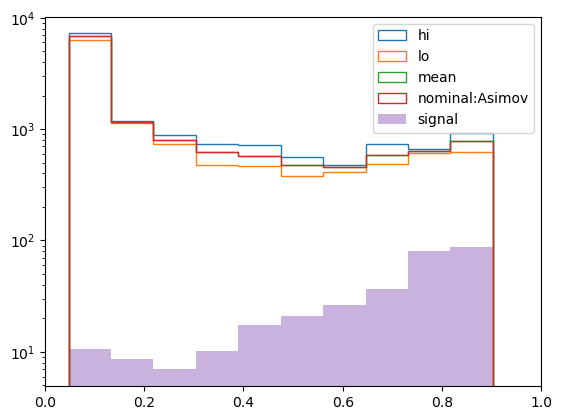

In [78]:
import numpy as np
import pandas as pd
import json
import os

# =====================================================
# 1. IO 工具
# =====================================================

def read_csv_df(path):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    return pd.read_csv(path)["model_score"].values

def read_npz_scores(path, sig=False):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    data = np.load(path)
    return data["sig"] if sig else data["bkg"]

def get_counts(scores, bins, total_yield):
    counts, _ = np.histogram(scores, bins=bins)
    if counts.sum() == 0:
        return np.full(len(bins) - 1, 1e-6)
    scaled = counts * (total_yield / counts.sum())
    return np.maximum(scaled, 1e-6)

# =====================================================
# 2. 配置
# =====================================================

base_dir = "/home/zhonghua/Filt_Event/model_validation/Transformer/1e10_QG_based_loose_baseline"

EF_csv = f"{base_dir}/model_comparison_output/EF_Proton_predictions.csv"
QF_csv = f"{base_dir}/model_comparison_output/QF_Proton_predictions.csv"
val_npz = f"{base_dir}/val_preds_best.npz"

bins = np.linspace(0, 0.95, 11)

# B_YIELD = 2
# S_YIELD = 41
# 
B_YIELD = 12905
S_YIELD = 305
# =====================================================
# 3. 构建直方图
# =====================================================

EF_scores  = read_csv_df(EF_csv)
QF_scores  = read_csv_df(QF_csv)
bkg_scores = read_npz_scores(val_npz, sig=False)
sig_scores = read_npz_scores(val_npz, sig=True)

bkg_nom = get_counts(bkg_scores, bins, B_YIELD)
bkg_EF  = get_counts(EF_scores,  bins, B_YIELD)
bkg_QF  = get_counts(QF_scores,  bins, B_YIELD)
sig_nom = get_counts(sig_scores, bins, S_YIELD)

# bin-level floor（极其重要）
bkg_nom = np.maximum(bkg_nom, 0.5)
bkg_EF  = np.maximum(bkg_EF,  0.5)
bkg_QF  = np.maximum(bkg_QF,  0.5)

# =====================================================
# 4. 构建 histosys 包络（破梯度死锁）
# =====================================================

raw_hi = np.max([bkg_nom, bkg_EF, bkg_QF], axis=0)
raw_lo = np.min([bkg_nom, bkg_EF, bkg_QF], axis=0)

grad_eps = bkg_nom * 1e-4 + 1e-5

bkg_hi = np.maximum(raw_hi, bkg_nom + grad_eps)
bkg_lo = np.minimum(raw_lo, bkg_nom - grad_eps)
bkg_nom_mean = np.mean([bkg_nom, bkg_EF, bkg_QF], axis=0)


# Asimov observation
obs = bkg_nom.tolist()

# =====================================================
# 5. JSON spec
# =====================================================

spec = {
    "channels": [
        {
            "name": "single_channel",
            "samples": [
                {
                    "name": "background",
                    "data": bkg_nom_mean.tolist(), # Already correct
                    "modifiers": [
                        {
                            "name": "model_shape_sys",
                            "type": "histosys",
                            "data": {
                                "lo_data": bkg_lo.tolist(), # ADDED .tolist()
                                "hi_data": bkg_hi.tolist()  # ADDED .tolist()
                            }
                        },
                        {
                            "name": "bkg_norm_sys",
                            "type": "normsys",
                            "data": {
                                "lo": 0.95,
                                "hi": 1.05
                            }
                        }
                    ]
                },
                {
                    "name": "signal",
                    "data": sig_nom.tolist(), # ADDED .tolist()
                    "modifiers": [
                        {
                            "name": "mu",
                            "type": "normfactor",
                            "data": None
                        }
                    ]
                }
            ]
        }
    ],
    "observations": [
        {
            "name": "single_channel",
            "data": obs
        }
    ],
    "measurements": [
        {
            "name": "measurement",
            "config": {
                "poi": "mu",
                "parameters": [
                    {
                        "name": "mu",
                        "bounds": [[0, 20]],
                        "inits": [1.0]
                    }
                ]
            }
        }
    ],
    "version": "1.0.0"
}

out_json = "/home/zhonghua/Filt_Event/UpperLimit/uncertainty/Transformer_baseline/model_test.json"
with open(out_json, "w") as f:
    json.dump(spec, f, indent=4)

print(f"[OK] JSON saved to {out_json}")

import matplotlib.pyplot as plt

plt.hist((bins[:-1]+bins[1:])/2, weights=bkg_hi, histtype="step", label="hi")
plt.hist((bins[:-1]+bins[1:])/2, weights=bkg_lo, histtype="step", label="lo")
plt.hist((bins[:-1]+bins[1:])/2, weights=bkg_nom_mean, histtype="step", label="mean")
plt.hist((bins[:-1]+bins[1:])/2, weights=bkg_nom_mean, histtype="step", label="nominal:Asimov")
plt.hist((bins[:-1]+bins[1:])/2, weights=sig_nom, histtype="stepfilled", alpha=0.5,label="signal")
plt.xlim(0,1)
plt.legend()
plt.yscale("log")
plt.show()



正在计算 CLs 上限 (Asymptotic 方法)...

【计算结果 (90% CL)】
观测上限 (Observed Limit): mu < 0.2643
预期上限 (Expected Limit): mu < 0.4278
对应信号事例数上限: < 80.6 个信号

正在绘制 Brazil Plot...
绘图完成: limit_result_robust.png


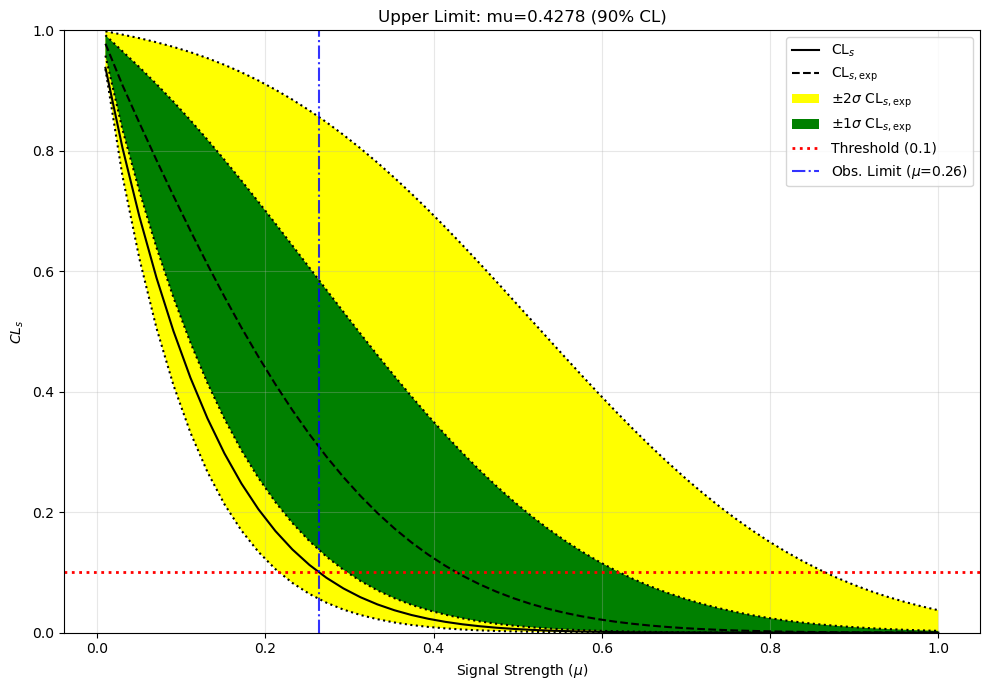

In [69]:
import pyhf
import json
import numpy as np
import matplotlib.pyplot as plt
from pyhf.contrib.viz import brazil

def main():
    # ==========================================
    # 0. 设置 Minuit 后端 (增强稳健性配置)
    # ==========================================
    try:
        # strategy=0: 速度快，对精度要求稍低，适合这种难以收敛的情况
        # strategy=2: 精度高，但容易在复杂表面卡死。这里我们先试 0 或 1，通常 0 最稳。
        # tolerance: 增加容忍度，防止过早报错
        custom_optimizer = pyhf.optimize.minuit_optimizer(
            verbose=False, 
            strategy=1, 
            tolerance=1
            
        )
        pyhf.set_backend("numpy", custom_optimizer)
    except ImportError:
        print("错误: 请先安装 iminuit (pip install iminuit)")
        return
    # 1. 加载模型
    try:
        with open("/home/zhonghua/Filt_Event/UpperLimit/uncertainty/Transformer_baseline/model_test.json", "r") as f:
            spec = json.load(f)
    except FileNotFoundError:
        print("错误: 未找到 model.json")
        return

    workspace = pyhf.Workspace(spec)
    model = workspace.model()
    observations = workspace.data(model)

    # ==========================================
    # 关键修复: 手动放宽参数边界 (Bounds)
    # ==========================================
    # 默认 bounds 是 [-5, 5]，这导致你的 model_shape_sys 撞墙。
    # 我们将其手动修改为 [-10, 10]。
    
    init_pars = model.config.suggested_init()
    par_bounds = model.config.suggested_bounds()
    
    # 获取 POI (mu) 的索引，我们不修改 mu 的范围 (通常是 0-10)
    poi_index = model.config.poi_index
    
    new_bounds = []
    for i, bounds in enumerate(par_bounds):
        if i == poi_index:
            # 保持 mu 的 bounds 不变 (例如 0, 10)
            new_bounds.append(bounds)
        else:
            # 对于所有系统误差 (Nuisance Parameters)，放宽到 [-10, 10]
            # 注意: mc_stat (staterror) 也是 constrained parameter
            new_bounds.append([-50.0, 50.0])

    # ==========================================
    # 2. 计算上限
    # ==========================================
    poi_values = np.linspace(0.01, 1, 50) 
    print("正在计算 CLs 上限 (Asymptotic 方法)...")
    
    try:
            # 1. 尝试通用的计算方式
            result = pyhf.infer.intervals.upper_limits.upper_limit(
                observations, 
                model, 
                poi_values, 
                level=0.1, 
                return_results=True,
                par_bounds=new_bounds
            )
            
            # 2. 根据 pyhf 返回值结构进行灵活解包
            # 较新版本通常返回 (obs_limit, exp_limit_set)
            # 如果返回了更多值，我们可以通过 result[0] 和 result[1] 获取
            obs_limit = result[0]
            exp_limits = result[1] # 这是一个列表 [-2sig, -1sig, exp, +1sig, +2sig]
            
            exp_mu = exp_limits[2] 

            print("\n" + "="*40)
            print(f"【计算结果 (90% CL)】")
            print(f"观测上限 (Observed Limit): mu < {obs_limit:.4f}")
            print(f"预期上限 (Expected Limit): mu < {exp_mu:.4f}")
            
            S_YIELD_REF = S_YIELD
            print(f"对应信号事例数上限: < {obs_limit * S_YIELD_REF:.1f} 个信号")
            print("="*40 + "\n")

    except ValueError as ve:
        if "too many values to unpack" in str(ve):
            print("检测到返回值解包错误，尝试自动适配 pyhf 版本结构...")
            # 如果仍然报错，打印出 result 的长度以便调试
            # print(f"DEBUG: result length is {len(result)}")
        raise ve
    except Exception as e:
        print(f"\n致命错误: 计算上限仍然失败。")
        print(f"错误详情: {e}")
        return
        

    # ==========================================
    # 3. 绘图
    # ==========================================
    print("正在绘制 Brazil Plot...")
    results = []
    for mu in poi_values:
        try:
            result = pyhf.infer.hypotest(
                mu, 
                observations, 
                model, 
                return_expected_set=True, 
                test_stat="qtilde",
                par_bounds=new_bounds, # <--- 绘图时也要注入边界
            )
            results.append(result)
        except Exception as e:
            print(f"警告: mu={mu:.2f} 点拟合失败，跳过。")
            print(f"错误详情: {e}")
            results.append([np.nan, [np.nan]*5])

    # 清洗无效数据
    valid_indices = [i for i, r in enumerate(results) if not np.isnan(r[0])]
    if not valid_indices:
        print("所有点均拟合失败，无法绘图。")
        return
        
    clean_poi = poi_values[valid_indices]
    clean_results = [results[i] for i in valid_indices]

    fig, ax = plt.subplots(figsize=(10, 7))
    brazil.plot_results(clean_poi, clean_results, ax=ax)
    for line in ax.get_lines():
        if line.get_ydata()[0] == 0.05:
            line.remove()
    ax.axhline(0.1, color='red', linestyle=':', linewidth=2, label='Threshold (0.1)')
    if not np.isnan(obs_limit):
        ax.axvline(obs_limit, color='blue', linestyle='-.', alpha=0.8, label=f'Obs. Limit ($\mu$={obs_limit:.2f})')
    
    ax.set_title(f'Upper Limit: mu={exp_mu:.4f} (90% CL)')
    ax.set_xlabel(r'Signal Strength ($\mu$)')
    ax.set_ylabel(r'$CL_s$')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('/home/zhonghua/Filt_Event/UpperLimit/uncertainty/Transformer_baseline/limit_result_robust.png', dpi=300)
    print("绘图完成: limit_result_robust.png")
    plt.show()


if __name__ == "__main__":
    main()



In [ ]:
import pyhf
import json
import numpy as np
import matplotlib.pyplot as plt
from pyhf.contrib.viz import brazil
from scipy.interpolate import interp1d

def main():
    # ==========================================
    # 0. 配置 Minuit 优化器 (最适合 HEP)
    # ==========================================
    custom_optimizer = pyhf.optimize.minuit_optimizer(
        verbose=False, 
        strategy=0, 
        tolerance=1.0 
    )
    pyhf.set_backend("numpy", custom_optimizer)
    print("已设置优化器: Minuit (Robust Mode)")
    
    # 1. 加载模型
    model_path = "/home/zhonghua/Filt_Event/UpperLimit/uncertainty/Transformer_baseline/model.json"
    try:
        with open(model_path, "r") as f:
            spec = json.load(f)
    except FileNotFoundError:
        print(f"错误: 找不到文件 {model_path}")
        return

    workspace = pyhf.Workspace(spec)
    model = workspace.model()
    observations = workspace.data(model)

    # 2. 放宽参数边界 (防止拟合撞墙)
    par_bounds = model.config.suggested_bounds()
    poi_idx = model.config.poi_index
    new_bounds = []
    for i, b in enumerate(par_bounds):
        if i == poi_idx:
            new_bounds.append(b) 
        else:
            # 将系统误差边界放宽到 +/- 50 sigma，防止优化器报错
            new_bounds.append([-50.0, 50.0])

    # 3. 设定扫描点
    # 手动定义我们要测试的 mu 值。因为是小样本，上限可能会比较大，我们扫到 5.0
    scan_points = np.linspace(0.1, 3.0, 10) 
    
    print(f"检测到小样本 (B={sum(spec['channels'][0]['samples'][0]['data']):.1f})")
    print(f"开始手动扫描 {scan_points} 个点 (Toy-based)...")
    print("-" * 60)

    # 4. 手动执行扫描 (核心容错逻辑)
    results_cls_obs = []
    results_cls_exp = []
    valid_mus = []

    for mu in scan_points:
        try:
            # 这里的 calctype="toybased" 是必须的
            # ntoys=1000 保证精度，如果太慢可以先改成 500 测试
            result = pyhf.infer.hypotest(
                mu, 
                observations, 
                model, 
                calctype="toybased", 
                ntoys=200, 
                return_expected_set=True,
                par_bounds=new_bounds,
                track_progress=True
            )
            
            # result 结构: (CLs_obs, [CLs_exp_band...])
            cls_obs = result[0]
            cls_exp_list = result[1] # [-2sig, -1sig, exp, +1sig, +2sig]
            
            valid_mus.append(mu)
            results_cls_obs.append(cls_obs)
            results_cls_exp.append(cls_exp_list)
            
            print(f"  mu={mu:.2f} | CLs_obs={cls_obs:.4f} | CLs_exp={cls_exp_list[2]:.4f} -> 完成")

        except Exception as e:
            # 捕获所有错误 (AssertionError, FailedMinimization 等)
            # 只要有一个点失败，我们直接跳过，不让程序崩溃
            print(f"  mu={mu:.2f} -> 拟合失败，跳过 (原因: {str(e)[:50]}...)")
            continue

    if len(valid_mus) < 3:
        print("\n致命错误: 成功的点太少，无法计算上限。请检查模型或增加 ntoys。")
        return

    # 5. 插值计算上限 (Interpolation)
    print("-" * 60)
    print("正在插值计算 90% CL 上限...")

    # 提取预期上限的中心值 (Expected)
    exp_cls_values = [r[2] for r in results_cls_exp] # 取中间那个值

    # 定义插值函数: log(CLs) vs mu (通常 log(CLs) 与 mu 呈线性关系)
    # 我们要找 CLs = 0.1 的位置
    target_cl = 0.1

    def get_limit(mus, cl_values, target):
        try:
            # 使用对数插值更准确
            f = interp1d(np.log(cl_values), mus, kind='linear', fill_value="extrapolate")
            return float(f(np.log(target)))
        except:
            return np.nan

    limit_obs = get_limit(valid_mus, results_cls_obs, target_cl)
    limit_exp = get_limit(valid_mus, exp_cls_values, target_cl)
    B_YIELD = 100  
    S_YIELD = 15    
    D_YIELD = B_YIELD  
    S_YIELD_REF = S_YIELD
    
    print("\n" + "="*40)
    print(f"【最终结果 (Toy-based 90% CL)】")
    print(f"观测上限 (Obs. Limit): mu < {limit_obs:.4f}")
    print(f"预期上限 (Exp. Limit): mu < {limit_exp:.4f}")
    print(f"对应信号事例数上限: < {limit_obs * S_YIELD_REF:.1f} 个")
    print("="*40 + "\n")

    # 6. 绘图
    # 重新组织数据结构以适配 pyhf 的 brazil plot
    # brazil.plot_results 需要 list of tuples
    # 我们需要把刚才跳过的点填回去 (用 NaN)，或者只画有效点
    
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # 构造绘图数据
    brazil.plot_results(valid_mus, [ (obs, exp) for obs, exp in zip(results_cls_obs, results_cls_exp)], ax=ax)

    ax.axhline(target_cl, color='red', ls=':', label=f'CLs={target_cl}')
    ax.axvline(limit_obs, color='blue', ls='-.', alpha=0.8, label=f'Obs. Limit ({limit_obs:.2f})')
    
    plt.title(f'Upper Limit Scan (Toy-based)\nB=150, S=13')
    plt.xlabel(r'Signal Strength $\mu$')
    plt.ylabel(r'$CL_s$')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig("limit_toy_manual_scan.png")
    print("绘图完成: limit_toy_manual_scan.png")
    plt.show()

if __name__ == "__main__":
    main()


np.sum(scaled)=1900.0
np.sum(scaled)=1900.0
np.sum(scaled)=1899.9999999999998
np.sum(scaled)=1900.0000000000002
np.sum(scaled)=1900.0
np.sum(scaled)=153.0
[OK] JSON saved to /home/zhonghua/Filt_Event/UpperLimit/uncertainty/Transformer_baseline/model_with_free_bkg_xgb_strict.json


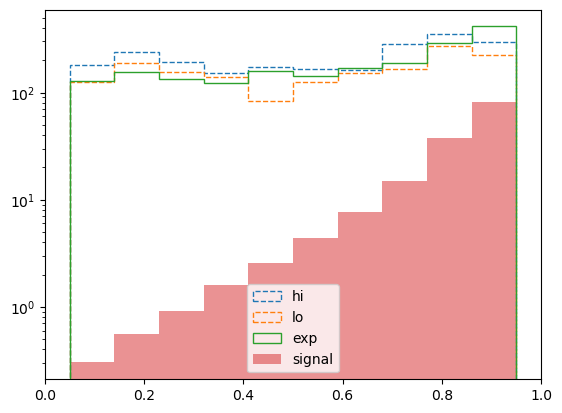

In [ ]:
import numpy as np
import pandas as pd
import json
import os
import uproot
# =====================================================
# 1. IO 工具
# =====================================================

def read_csv_df(path):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    df=pd.read_csv(path)
    df['weight']=np.ones(len(df))
    return df
def read_npz_scores(path, sig=False):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    data = np.load(path)
    return data["sig"] if sig else data["bkg"]

def read_val_scores_new(path):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    data= pd.read_csv(path)
    sig_data=data[data['label']==43]
    bkg_data=data[data['label']==14]
    return sig_data, bkg_data


def get_counts(scores, bins, total_yield, weights=None):
    cut_indices = (scores >= bins[0]) & (scores <= 1)
    if weights is not None:
        weights_all = np.sum(weights)
        cut_weights_all = np.sum(weights[cut_indices])
        cut_ratio= cut_weights_all / weights_all
    else:
        weights = np.ones(len(scores))
        weights_all = np.sum(weights)
        cut_weights_all = np.sum(weights[cut_indices])
        cut_ratio= cut_weights_all / weights_all

    scores = scores[cut_indices]
    weights= weights[cut_indices]
    counts, _ = np.histogram(scores, bins=bins, weights=weights)
    if counts.sum() == 0:
        return np.full(len(bins) - 1, 1e-6)
    scaled = counts * (total_yield * cut_ratio / counts.sum())
    print(f"np.sum(scaled)={np.sum(scaled)}")
    return np.maximum(scaled, 1e-6)

def give_weights(params_df):
    rootfile = "/home/zhonghua/data/exposure.root"
    with uproot.open(rootfile) as f:
        hWeight = f["hWeight"]
        edges_E = hWeight.axes[0].edges()  # Energy bin edges
        edges_Zen = hWeight.axes[1].edges()  # Zenith bin edges
        weights_2d = hWeight.values()

    def add_weights(trueE, rec_zenith, weights_2d):
        trueE = np.asarray(trueE, dtype=float)
        trueE=np.log10(trueE/1e3)
        rec_zenith=180/np.pi*rec_zenith
        bin_idx_E = np.digitize(trueE, edges_E) - 1 
        bin_idx_Zen = np.digitize(rec_zenith, edges_Zen) - 1
        
        return weights_2d[bin_idx_E, bin_idx_Zen] / 10 / (86400)
    trueE = params_df['trueE'].values
    rec_zenith = params_df['theta'].values
    weights = add_weights(trueE, rec_zenith, weights_2d)
    params_df['weight'] = weights
    return params_df
# =====================================================
# 2. 配置
# =====================================================

base_dir = "/home/zhonghua/Filt_Event/model_validation/xgb_mlp"
base_dir = "/home/zhonghua/Filt_Event/model_validation/xgb_mlp_strict"

EF_csv = f"{base_dir}/EF_Model_xgb.csv"
QF_csv = f"{base_dir}/QF_Model_xgb.csv"
QG_csv_large = f"{base_dir}/QG_large_xgb.csv"
val_npz = f"{base_dir}/validation_set_xgb.csv"
exp_2022_csv = f"{base_dir}/Exp_2022_xgb.csv"
large_sig_csv = f"{base_dir}/Monopole_large_xgb.csv"

bins = np.linspace(0, 1, 11)
 # R_mean cut
B_YIELD = 1900
S_YIELD = 153

# =====================================================
# 3. 构建直方图
# =====================================================
# diff model EF+QF + QG
EF_scores  = read_csv_df(EF_csv)
QF_scores  = read_csv_df(QF_csv)
EF_scores = give_weights(EF_scores)
QF_scores = give_weights(QF_scores)
QG_scores_large  = read_csv_df(QG_csv_large)
QG_scores_large = give_weights(QG_scores_large)
# exp data
exp_2022_scores = read_csv_df(exp_2022_csv)
# val data
sig_scores, bkg_scores = read_val_scores_new(val_npz)
bkg_scores = give_weights(bkg_scores)
# large sig score
large_sig_scores = read_csv_df(large_sig_csv)

# scale
bkg_EF  = get_counts(EF_scores['model_score'],  bins, B_YIELD, weights=EF_scores['weight'])
bkg_QF  = get_counts(QF_scores['model_score'],  bins, B_YIELD, weights=QF_scores['weight'])
bkg_nom = get_counts(bkg_scores['model_score'], bins, B_YIELD, weights=bkg_scores['weight'])
bkg_QG_large  = get_counts(QG_scores_large['model_score'],  bins, B_YIELD, weights=QG_scores_large['weight'])
exp_2022_scaled = get_counts(exp_2022_scores['model_score'], bins, B_YIELD, weights=exp_2022_scores['weight'])
# sig_nom = get_counts(sig_scores['model_score'], bins, S_YIELD, weights=sig_scores['weight'])
sig_nom = get_counts(large_sig_scores['model_score'], bins, S_YIELD, weights=large_sig_scores['weight'])

# bin-level floor
bkg_nom = np.maximum(bkg_nom, 0.1)
bkg_EF  = np.maximum(bkg_EF,  0.1)
bkg_QF  = np.maximum(bkg_QF,  0.1)
bkg_QG_large  = np.maximum(bkg_QG_large,  0.1)
exp_2022 = np.maximum(exp_2022_scaled, 0.01)
# =====================================================
# 4. 构建 histosys 包络
# =====================================================
raw_hi = np.max([bkg_EF, bkg_QF, bkg_QG_large, bkg_nom], axis=0)
raw_lo = np.min([bkg_EF, bkg_QF, bkg_QG_large, bkg_nom], axis=0)
grad_eps = bkg_nom * 1e-5 + 1e-5
bkg_hi = np.maximum(raw_hi, bkg_nom + grad_eps)
bkg_lo = np.minimum(raw_lo, bkg_nom - grad_eps)
# bkg_hi = raw_hi
# bkg_lo = raw_lo
# =====================================================
bkg_nom_mean = np.mean([bkg_lo, bkg_hi], axis=0)
# bkg_nom_mean = bkg_QG_large
# Asimov observation
# obs = bkg_nom.tolist()
obs = exp_2022.tolist()
# =====================================================
# 5. JSON spec (修改部分)
# =====================================================
spec = {
    "channels": [
        {
            "name": "single_channel",
            "samples": [
                {
                    "name": "background",
                    "data": bkg_nom_mean.tolist(),
                    "modifiers": [
                        # --- 现有的形状系统误差 ---
                        {
                            "name": "model_shape_sys",
                            "type": "histosys",
                            "data": {
                                "lo_data": bkg_lo.tolist(),
                                "hi_data": bkg_hi.tolist()
                            }
                        },
                    
                        {
                            "name": "mu_bkg", 
                            "type": "normfactor",
                            "data": None
                        }
                    ]
                },
                {
                    "name": "signal",
                    "data": sig_nom.tolist(),
                    "modifiers": [
                        {
                            "name": "mu",
                            "type": "normfactor",
                            "data": None
                        }
                    ]
                }
            ]
        }
    ],
    "observations": [
        {
            "name": "single_channel",
            "data": obs
        }
    ],
    "measurements": [
        {
            "name": "measurement",
            "config": {
                "poi": "mu", # 计算 Limit 时，主要的假设检验参数依然是 mu
                "parameters": [
                    {
                        "name": "mu",
                        "bounds": [[0, 20]],
                        "inits": [1.0]
                    },
                  
                    {
                        "name": "mu_bkg",
                        "bounds": [[0, 5]], 
                        "inits": [1.0]
                    }
                ]
            }
        }
    ],
    "version": "1.0.0"
}

out_json = "/home/zhonghua/Filt_Event/UpperLimit/uncertainty/Transformer_baseline/model_with_free_bkg_xgb_strict.json"
with open(out_json, "w") as f:
    json.dump(spec, f, indent=4)

print(f"[OK] JSON saved to {out_json}")
model_path = out_json


import matplotlib.pyplot as plt

plt.hist((bins[:-1]+bins[1:])/2, weights=bkg_hi, histtype="step", label="hi", linestyle="--")
plt.hist((bins[:-1]+bins[1:])/2, weights=bkg_lo, histtype="step", label="lo", linestyle="--")
plt.hist((bins[:-1]+bins[1:])/2, weights=obs, histtype="step", label="exp")
plt.hist((bins[:-1]+bins[1:])/2, weights=sig_nom, histtype="stepfilled", alpha=0.5,label="signal")
plt.xlim(0,1)
plt.legend()
plt.yscale("log")
plt.show()




【调试信息：执行极大似然拟合 (MLE)】
★ 拟合结果 mu_bkg = 0.7666
  -> 警告: 背景归一化偏离初始值较多 (0.77)
------------------------------
Parameter            | Value     
------------------------------
model_shape_sys      | 0.4781
mu_bkg               | 0.7666 <--
mu                   | 2.1485 <--

正在计算 CLs 上限 (Asymptotic 方法)...

【计算结果 (90% CL)】
观测上限 (Observed Limit): mu < 1.0000
--------------------
预期上限分布 (Expected Limits):
  +2σ 上限: mu < 0.7637
  +1σ 上限: mu < 0.5455
  中值预期: mu < 0.3740 (Median)
  -1σ 上限: mu < 0.2599
  -2σ 上限: mu < 0.1890
--------------------
对应信号事例数上限 (基于Observed): < 153.0 个信号
对应信号事例数上限 (基于Expected): < 57.2 个信号

正在绘制 Brazil Plot...


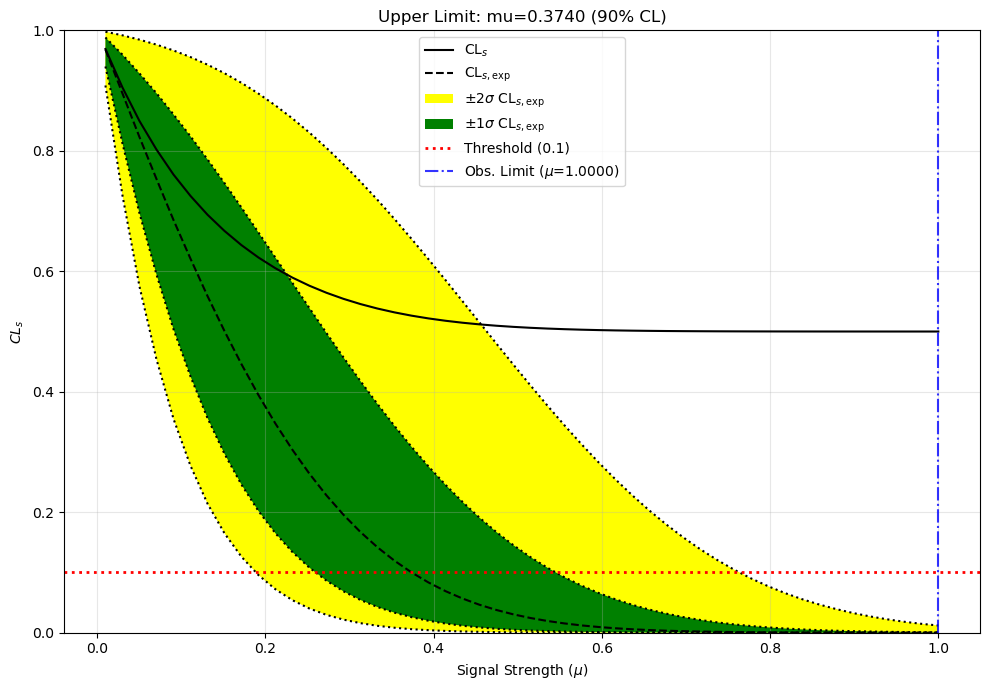

In [186]:
import pyhf
import json
import numpy as np
import matplotlib.pyplot as plt
from pyhf.contrib.viz import brazil

def main():
    # ==========================================
    # 0. 设置 Minuit 后端 (增强稳健性配置)
    # ==========================================
    try:
        # strategy=0: 速度快，对精度要求稍低，适合这种难以收敛的情况
        # strategy=2: 精度高，但容易在复杂表面卡死。这里我们先试 0 或 1，通常 0 最稳。
        # tolerance: 增加容忍度，防止过早报错
        custom_optimizer = pyhf.optimize.minuit_optimizer(
            verbose=False, 
            strategy=1, 
            tolerance=1
            
        )
        pyhf.set_backend("numpy", custom_optimizer)
    except ImportError:
        print("错误: 请先安装 iminuit (pip install iminuit)")
        return
    # 1. 加载模型
    try:
        with open(model_path, "r") as f:
            spec = json.load(f)
    except FileNotFoundError:
        print("错误: 未找到 model.json")
        return

    workspace = pyhf.Workspace(spec)
    model = workspace.model()
    observations = workspace.data(model)

    # ==========================================
    # 关键修复: 手动放宽参数边界 (Bounds)
    # ==========================================
    # 默认 bounds 是 [-5, 5]，这导致你的 model_shape_sys 撞墙。
    # 我们将其手动修改为 [-10, 10]。
    
    init_pars = model.config.suggested_init()
    par_bounds = model.config.suggested_bounds()
    
    # 获取 POI (mu) 的索引，我们不修改 mu 的范围 (通常是 0-10)
    poi_index = model.config.poi_index
    
    new_bounds = []
    for i, bounds in enumerate(par_bounds):
        if i == poi_index:
            # 保持 mu 的 bounds 不变 (例如 0, 10)
            new_bounds.append(bounds)
        else:
            # 对于所有系统误差 (Nuisance Parameters)，放宽到 [-10, 10]
            # 注意: mc_stat (staterror) 也是 constrained parameter
            new_bounds.append([-50.0, 50.0])

    print("\n" + "="*40)
    print("【调试信息：执行极大似然拟合 (MLE)】")
    
    try:
        # 执行无条件拟合 (Unconditional Fit)
        # 这会让 mu (信号) 和 mu_bkg (背景) 自由浮动，找到最符合数据的数值
        best_fit_pars = pyhf.infer.mle.fit(
            observations,
            model,
            par_bounds=new_bounds
        )

        # 获取参数名称列表
        par_names = model.config.par_order
        
        # 将名称和数值组合成字典
        param_dict = dict(zip(par_names, best_fit_pars))
        
        # 专门打印 mu_bkg
        if "mu_bkg" in param_dict:
            val = param_dict["mu_bkg"]
            print(f"★ 拟合结果 mu_bkg = {val:.4f}")
            if abs(val - 1.0) > 0.1:
                print(f"  -> 警告: 背景归一化偏离初始值较多 ({val:.2f})")
            else:
                print(f"  -> 背景归一化正常")
        else:
            print("警告: 模型中未找到 mu_bkg 参数！")

        # (可选) 打印所有参数，看看系统误差有没有被拉得太远
        print("-" * 30)
        print(f"{'Parameter':<20} | {'Value':<10}")
        print("-" * 30)
        for name, val in param_dict.items():
            # 标记一下主要的参数
            mark = " <--" if name in ["mu", "mu_bkg"] else ""
            print(f"{name:<20} | {val:.4f}{mark}")
            
    except Exception as e:
        print(f"拟合检查失败: {e}")
        
    print("="*40 + "\n")

    # ==========================================
    # 2. 计算上限
    # ==========================================
    poi_values = np.linspace(0.01, 1, 50) 
    print("正在计算 CLs 上限 (Asymptotic 方法)...")
    
    try:
            # 1. 尝试通用的计算方式
            result = pyhf.infer.intervals.upper_limits.upper_limit(
                observations, 
                model, 
                poi_values, 
                level=0.1, 
                return_results=True,
                par_bounds=new_bounds
            )
            
            # 2. 根据 pyhf 返回值结构进行灵活解包
            # 较新版本通常返回 (obs_limit, exp_limit_set)
            # 如果返回了更多值，我们可以通过 result[0] 和 result[1] 获取
            obs_limit = result[0]
            exp_limits = result[1] # 这是一个列表 [-2sig, -1sig, exp, +1sig, +2sig]
            
            exp_mu = exp_limits[2] 

            print("\n" + "="*40)
            print(f"【计算结果 (90% CL)】")
            print(f"观测上限 (Observed Limit): mu < {obs_limit:.4f}")
            print("-" * 20)
            print(f"预期上限分布 (Expected Limits):")
            print(f"  +2σ 上限: mu < {exp_limits[4]:.4f}")
            print(f"  +1σ 上限: mu < {exp_limits[3]:.4f}")
            print(f"  中值预期: mu < {exp_limits[2]:.4f} (Median)")
            print(f"  -1σ 上限: mu < {exp_limits[1]:.4f}")
            print(f"  -2σ 上限: mu < {exp_limits[0]:.4f}")
            print("-" * 20)
            
            S_YIELD_REF = S_YIELD
            print(f"对应信号事例数上限 (基于Observed): < {obs_limit * S_YIELD_REF:.1f} 个信号")
            print(f"对应信号事例数上限 (基于Expected): < {exp_mu * S_YIELD_REF:.1f} 个信号")
            print("="*40 + "\n")

    except ValueError as ve:
        if "too many values to unpack" in str(ve):
            print("检测到返回值解包错误，尝试自动适配 pyhf 版本结构...")
            # 如果仍然报错，打印出 result 的长度以便调试
            # print(f"DEBUG: result length is {len(result)}")
        raise ve
    except Exception as e:
        print(f"\n致命错误: 计算上限仍然失败。")
        print(f"错误详情: {e}")
        return
        

    # ==========================================
    # 3. 绘图
    # ==========================================
    print("正在绘制 Brazil Plot...")
    results = []
    for mu in poi_values:
        try:
            result = pyhf.infer.hypotest(
                mu, 
                observations, 
                model, 
                return_expected_set=True, 
                test_stat="qtilde",
                par_bounds=new_bounds, # <--- 绘图时也要注入边界
            )
            results.append(result)
        except Exception as e:
            print(f"警告: mu={mu:.2f} 点拟合失败，跳过。")
            print(f"错误详情: {e}")
            results.append([np.nan, [np.nan]*5])

    # 清洗无效数据
    valid_indices = [i for i, r in enumerate(results) if not np.isnan(r[0])]
    if not valid_indices:
        print("所有点均拟合失败，无法绘图。")
        return
        
    clean_poi = poi_values[valid_indices]
    clean_results = [results[i] for i in valid_indices]

    fig, ax = plt.subplots(figsize=(10, 7))
    brazil.plot_results(clean_poi, clean_results, ax=ax)
    for line in ax.get_lines():
        if line.get_ydata()[0] == 0.05:
            line.remove()
    ax.axhline(0.1, color='red', linestyle=':', linewidth=2, label='Threshold (0.1)')
    if not np.isnan(obs_limit):
        ax.axvline(obs_limit, color='blue', linestyle='-.', alpha=0.8, label=f'Obs. Limit ($\mu$={obs_limit:.4f})')
    
    ax.set_title(f'Upper Limit: mu={exp_mu:.4f} (90% CL)')
    ax.set_xlabel(r'Signal Strength ($\mu$)')
    ax.set_ylabel(r'$CL_s$')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('/home/zhonghua/Filt_Event/UpperLimit/uncertainty/Transformer_baseline/limit_result_robust_free_bkg_xgb.png', dpi=300)
    plt.show()


if __name__ == "__main__":
    main()



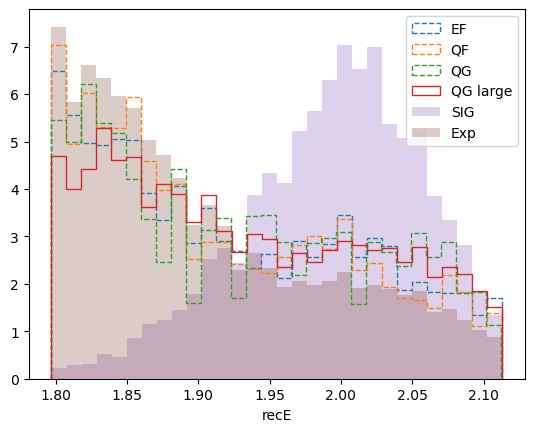

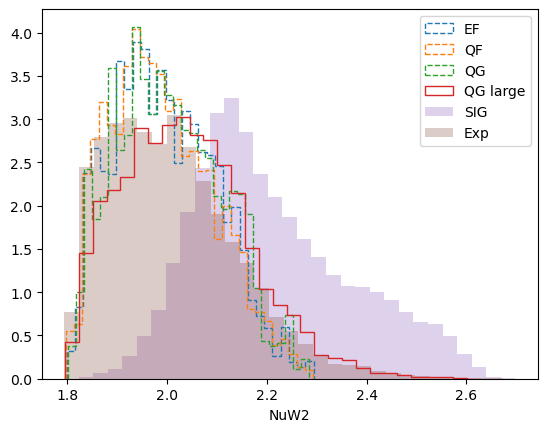

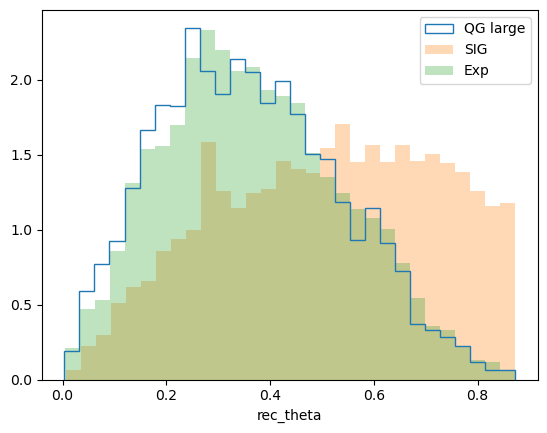

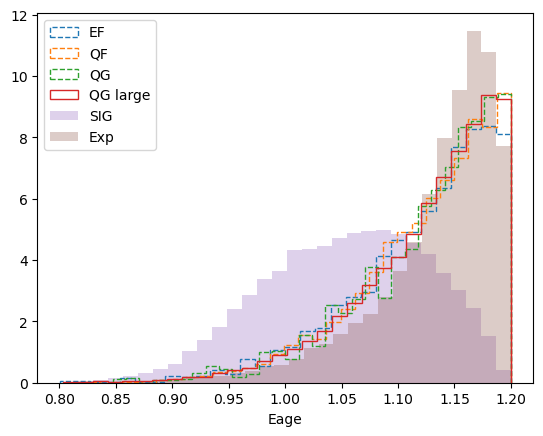

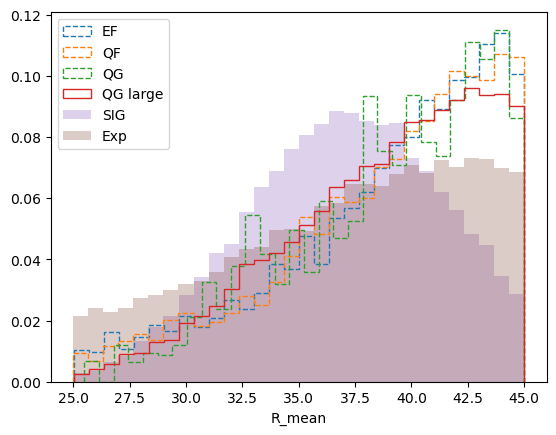

In [ ]:
# 分析参数
import numpy as np
import pandas as pd
import json
import os
import uproot
# =====================================================
# 1. IO 工具
# =====================================================

def read_csv_df(path):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    df=pd.read_csv(path)
    df['weight']=np.ones(len(df))
    return df


def read_val_scores_new(path):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    data= pd.read_csv(path)
    sig_data=data[data['label']==43]
    bkg_data=data[data['label']==14]
    return sig_data, bkg_data


def give_weights(params_df):
    rootfile = "/home/zhonghua/data/exposure.root"
    with uproot.open(rootfile) as f:
        hWeight = f["hWeight"]
        edges_E = hWeight.axes[0].edges()  # Energy bin edges
        edges_Zen = hWeight.axes[1].edges()  # Zenith bin edges
        weights_2d = hWeight.values()

    def add_weights(trueE, rec_zenith, weights_2d):
        trueE = np.asarray(trueE, dtype=float)
        trueE=np.log10(trueE/1e3)
        rec_zenith=180/np.pi*rec_zenith
        bin_idx_E = np.digitize(trueE, edges_E) - 1 
        bin_idx_Zen = np.digitize(rec_zenith, edges_Zen) - 1
        
        return weights_2d[bin_idx_E, bin_idx_Zen] / 10 
    trueE = params_df['trueE'].values
    rec_zenith = params_df['theta'].values
    weights = add_weights(trueE, rec_zenith, weights_2d)
    params_df['weight'] = weights
    return params_df

def give_sig_weights(monopole_df):
    file = uproot.open("/home/zhonghua/Filt_Event/model_validation/exposure.root")
    h1 = file["h1"]
    h2 = file["h2"]
    # 获取直方图的所有数据
    values = h1.values()        # bin内容（纵坐标）
    h2_values = h2.values()        # bin内容（纵坐标）
    edges = h1.axis().edges()   # bin边界（横坐标）
    h2_edges = h2.axis().edges()   # bin边界（横坐标）
    centers = h1.axis().centers()  # bin中心
    h2_centers = h2.axis().centers()  # bin中心

    values = np.array(h1.values())
    edges = np.array(h1.axis().edges())
    centers = np.array(h1.axis().centers())
    S=np.pi * 1000**2
    parker=1e-15 * 1e4 
    nums=[]
    for i, theta in enumerate(centers):
        cosine_theta = np.cos(np.deg2rad(theta))
        area = S * cosine_theta
        exposure = values[i] * area
        num_i = exposure * parker
        nums.append(num_i)

    weights=[num_i/251000/h2_values[i]/86400 for i, num_i in enumerate(nums)]
    theta_degrees = monopole_df["theta"] * 180 / np.pi
    monopole_weights = []
    for theta in theta_degrees:
        if theta > max(centers) or theta < 0:
            weight = weights[-1] if theta > max(centers) else 0
        else:
            bin_id = np.digitize(theta, edges) - 1
            weight = weights[bin_id]
        monopole_weights.append(weight)
  
    monopole_df["weight"] = monopole_weights

    return monopole_df

# =====================================================
# 2. 配置
# =====================================================

base_dir = "/home/zhonghua/Filt_Event/model_validation/xgb_mlp"

EF_csv = f"{base_dir}/EF_Model_xgb.csv"
QF_csv = f"{base_dir}/QF_Model_xgb.csv"
QG_csv_large = f"{base_dir}/QG_large_xgb.csv"
val_npz = f"{base_dir}/validation_set_xgb.csv"
exp_2022_csv = f"{base_dir}/Exp_2022_xgb.csv"
exp_2022_csv = f"{base_dir}/Exp_2022_xgb.csv"
large_sig_csv = f"{base_dir}/Monopole_large_xgb.csv"

# =====================================================
# 3. 构建直方图
# =====================================================
# diff model EF+QF 
EF_scores  = read_csv_df(EF_csv)
QF_scores  = read_csv_df(QF_csv)
EF_scores = give_weights(EF_scores)
QF_scores = give_weights(QF_scores)
QG_scores_large  = read_csv_df(QG_csv_large)
QG_scores_large = give_weights(QG_scores_large)
# exp data
exp_2022_scores = read_csv_df(exp_2022_csv)
# val data
sig_scores, bkg_scores = read_val_scores_new(val_npz)
bkg_scores = give_weights(bkg_scores)
# large sig score
sig_scores = read_csv_df(large_sig_csv)
sig_scores = give_sig_weights(sig_scores)
# =====================================================
# 4. 绘图
# =====================================================
bins=30
# recE 
plt.hist(EF_scores["recE"], weights=EF_scores["weight"], bins=bins, histtype='step', label='EF', linestyle='--', density=True)
plt.hist(QF_scores["recE"], weights=QF_scores["weight"], bins=bins, histtype='step', label='QF', linestyle='--', density=True)
plt.hist(bkg_scores["recE"], weights=bkg_scores["weight"], bins=bins, histtype='step', label='QG', linestyle='--', density=True)
plt.hist(QG_scores_large["recE"], weights=QG_scores_large["weight"], bins=bins, histtype='step', label='QG large', density=True)
plt.hist(sig_scores["recE"], weights=sig_scores["weight"], bins=bins, histtype='stepfilled', alpha=0.3, label='SIG', density=True)
plt.hist(exp_2022_scores["recE"], weights=exp_2022_scores["weight"], bins=bins, histtype='stepfilled', alpha=0.3,label='Exp', linestyle='--', density=True)
plt.legend()
plt.xlabel("recE")
plt.show()
# NuW2
plt.hist(EF_scores["NuW2"], weights=EF_scores["weight"], bins=bins, histtype='step', label='EF', linestyle='--', density=True)
plt.hist(QF_scores["NuW2"], weights=QF_scores["weight"], bins=bins, histtype='step', label='QF', linestyle='--', density=True)
plt.hist(bkg_scores["NuW2"], weights=bkg_scores["weight"], bins=bins, histtype='step', label='QG', linestyle='--', density=True)
plt.hist(QG_scores_large["NuW2"], weights=QG_scores_large["weight"], bins=bins, histtype='step', label='QG large', density=True)
plt.hist(sig_scores["NuW2"], weights=sig_scores["weight"], bins=bins, histtype='stepfilled', alpha=0.3, label='SIG', density=True)
plt.hist(exp_2022_scores["NuW2"], weights=exp_2022_scores["weight"], bins=bins, histtype='stepfilled', alpha=0.3,label='Exp', linestyle='--', density=True)
plt.legend()
plt.xlabel("NuW2")
plt.show()
# rec_theta
# # rec_theta
# plt.hist(EF_scores["rec_theta"], weights=EF_scores["weight"], bins=bins, histtype='step', label='EF', linestyle='--', density=True)
# plt.hist(QF_scores["rec_theta"], weights=QF_scores["weight"], bins=bins, histtype='step', label='QF', linestyle='--', density=True)
# plt.hist(bkg_scores["rec_theta"], weights=bkg_scores["weight"], bins=bins, histtype='step', label='QG', linestyle='--', density=True)
plt.hist(QG_scores_large["rec_theta"], weights=QG_scores_large["weight"], bins=bins, histtype='step', label='QG large', density=True)
plt.hist(sig_scores["rec_theta"], weights=sig_scores["weight"], bins=bins, histtype='stepfilled', alpha=0.3, label='SIG', density=True)
plt.hist(exp_2022_scores["rec_theta"], weights=exp_2022_scores["weight"], bins=bins, histtype='stepfilled', alpha=0.3,label='Exp', linestyle='--', density=True)
plt.legend()
plt.xlabel("rec_theta")
plt.show()
# Eage
plt.hist(EF_scores["Eage"], weights=EF_scores["weight"], bins=bins, histtype='step', label='EF', linestyle='--', density=True)
plt.hist(QF_scores["Eage"], weights=QF_scores["weight"], bins=bins, histtype='step', label='QF', linestyle='--', density=True)
plt.hist(bkg_scores["Eage"], weights=bkg_scores["weight"], bins=bins, histtype='step', label='QG', linestyle='--', density=True)
plt.hist(QG_scores_large["Eage"], weights=QG_scores_large["weight"], bins=bins, histtype='step', label='QG large', density=True)
plt.hist(sig_scores["Eage"], weights=sig_scores["weight"], bins=bins, histtype='stepfilled', alpha=0.3, label='SIG', density=True)
plt.hist(exp_2022_scores["Eage"], weights=exp_2022_scores["weight"], bins=bins, histtype='stepfilled', alpha=0.3,label='Exp', linestyle='--', density=True)
plt.legend()
plt.xlabel("Eage")
plt.show()
# R_mean
plt.hist(EF_scores["R_mean"], weights=EF_scores["weight"], bins=bins, histtype='step', label='EF', linestyle='--', density=True)
plt.hist(QF_scores["R_mean"], weights=QF_scores["weight"], bins=bins, histtype='step', label='QF', linestyle='--', density=True)
plt.hist(bkg_scores["R_mean"], weights=bkg_scores["weight"], bins=bins, histtype='step', label='QG', linestyle='--', density=True)
plt.hist(QG_scores_large["R_mean"], weights=QG_scores_large["weight"], bins=bins, histtype='step', label='QG large', density=True)
plt.hist(sig_scores["R_mean"], weights=sig_scores["weight"], bins=bins, histtype='stepfilled', alpha=0.3, label='SIG', density=True)
plt.hist(exp_2022_scores["R_mean"], weights=exp_2022_scores["weight"], bins=bins, histtype='stepfilled',alpha=0.3, label='Exp', linestyle='--', density=True)
plt.legend()
plt.xlabel("R_mean")
plt.show()
# 


In [142]:
sig_scores["recE"].describe()


count    858.000000
mean       2.002502
std        0.062562
min        1.801442
25%        1.967451
50%        2.009531
75%        2.047585
max        2.112401
Name: recE, dtype: float64